In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from random import randint
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
#https://www.pnas.org/content/104/21/8685/tab-figures-data

In [2]:
### GENERAL NETWORK ANALYSIS FUNCTIONS

def plotDegsCCDF(Go): #Plots CCDF of degrees given a network
    degrees = Go.degree()
    kmax    = 0
    kis     = []
    # tabulate and display the CCDF Pr(K>=k)
    for _,ki in degrees:
        kis.append(ki)
        if ki > kmax: kmax = ki

    counts, bins = np.histogram(kis, bins=[i for i in range(kmax+2)], density=True)
    cumcounts = np.cumsum(counts)
    cumcounts = np.insert(cumcounts,0,0)
    plt.loglog(bins[1:-1], 1-cumcounts[1:-1], 'rs', alpha=0.5)
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.show()
    return

def calculateMeanGeodesic(Go):
    n = Go.number_of_nodes()#function for number of nodes
    m = Go.size() #function for number of edges

    dij = dict(nx.all_pairs_shortest_path_length(Go)) # APSP on G, store as a dictionary (tricky :)
    mean_geo_path_per_Node = [] # store average path length from any given nodes
    for i in dij.values(): #iterate through each dict of shortest pathes per node
        node = []
        for x in i.values(): #iterate through shortest pathes for each node
            if x != 0: # if path length doesn't equal zero then append to shortest pathes
                node.append(x)
        if len(node)!=0: #if node has any nodes attached then find the mean shortest path and add to list of all nodes
            mean_geo_path_per_Node.append(np.mean(node))
    ellmean = np.mean(mean_geo_path_per_Node)#add mean of graph to ellms array
    return ellmean

def summaryStats(Go, bipartite = True):
    n = Go.number_of_nodes()#function for number of nodes
    m = Go.size() #function for number of edges
    kmean = m*2/n #mean of in directed degree is edges/number of nodes
    ellmean = calculateMeanGeodesic(Go)

    print(f'number of nodes, n  = {n}')
    print(f'number of edges, m  = {m}')
    print(f'mean degree,    <k> = %5.2f' % kmean)
    print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)
    if not bipartite:
        C = nx.transitivity(Go)# C 
        print(f'clustering coefficient, C     = %5.2f' % C)

In [3]:
# CUSTOM FUNCTIONS FOR DISEASOME DATA 

# seperateType: takes a bipartite network and takes projects it given a type ('gene' or 'disease' in our case)
def seperateType(Go, IsolateType): # seperate bipartite graph into projections
    G_new = nx.Graph() #make new graph
    
    for i in Go.nodes(): #create edge between i and p, where p is the nodes that i -> other group -> p
        if Go.node[i]['Type'] == IsolateType: #if type we want
            
            neighbors = list(Go.neighbors(i))#make list of neighbors
            compression = len(neighbors)#store the amount of original neighbors and store as attribute
            G_new.add_node(i, Type = Go.node[i]['Type'], Class = Go.node[i]['Class'], 
                                                           Compressed_Neighbors = compression)
            add = {} #before adding second neighbors store the amount of shared (genes or diseases)
            
            for neighbor in neighbors: #For each neighbor find second neighbors
                for second_neighbor in list(Go.neighbors(neighbor)):
                    
                    if second_neighbor in add: #already shared gene so increment
                        add[second_neighbor] = add[second_neighbor] + 1
                        
                    else:
                        add[second_neighbor] = 1 #first time seeing this (gene/disease) so add common connections 1
            
            for key, value in add.items(): #now go through and add edges with found wieghts
                if i != key: #No self loops :P
                    G_new.add_edge(i, key, weight = value)
            
    return G_new #return 1-partite graph
    
# removeSingletons: given a graph return a copy of it without the singletons
def removeSingletons(Go): #this function is to make a new graph without singletons located in input graph
    G_new = Go.copy()
    for i in Go.nodes():
        if G_new.degree(i) == 0: #for every node that has degree 0 delete
            G_new.remove_node(i)
    return G_new

# largestComponent
def breadthFirstTraversal(Go, bipartite = True): #return a largest subset graph of GO
    G_new = nx.Graph() #new graph
    
    #find LCC and assume it is contained in largest connected subgraph
    max_i = 0
    max_deg = 0
    for i,j in Go.degree():
        if j > max_deg:
            max_deg = j
            max_i = i
    print("Starting at:", max_i)
    #store explored and unexplored nodes
    unexplored_nodes = [max_i]
    current = unexplored_nodes[0]
    explored_nodes = []
    if not bipartite:
        G_new.add_node(current, Type = Go.node[current]['Type'], Class = Go.node[current]['Class'], Compressed_Neighbors = Go.node[current]['Compressed_Neighbors'])
    else:
        G_new.add_node(current, Type = Go.node[current]['Type'], Class = Go.node[current]['Class'])

    while len(unexplored_nodes) > 0:
        # go to front of queue and explore node 0
        current = unexplored_nodes[0] 
        nieghbors = list(Go.neighbors(current))
        for i in nieghbors:# go through neighbors depthfirst and build subgraph
            if i not in unexplored_nodes and i not in explored_nodes:
                unexplored_nodes.append(i)
                if not bipartite:
                    G_new.add_node(i, Type = Go.node[i]['Type'], Class = Go.node[i]['Class'], Compressed_Neighbors = Go.node[i]['Compressed_Neighbors'])
                else:
                    G_new.add_node(i, Type = Go.node[i]['Type'], Class = Go.node[i]['Class'])
                G_new.add_edge(current, i)
                
        unexplored_nodes.remove(current) #delete from unexplored
        explored_nodes.append(current) #add to explored
                               
    return G_new


In [9]:
# plotGraph: layout graph to show structure and imitate https://www.pnas.org/content/104/21/8685
def plotGraph(Graph, ColorBy, bipartite = False, all_connected = False): #node_size = True,
 
    # Initialize figure
    plt.figure(figsize=(15,15))
    
    # Use spring_layout if not connected, this is because kamada will overlap unconnected sections
#     if all_connected:
#         pos = nx.kamada_kawai_layout(Graph)
#     else:
#         pos = nx.spring_layout(Graph, seed = 1, weight = "weight", k= 1/Graph.size()**0.3, iterations = 100)
    
    # Define colors for given category
    if ColorBy == "Type":
        color = {'disease':'#7497bc','gene':'#e78c61'}
        
    elif ColorBy == "Class" :
        color = {'Neurological' : "#e6194B",
                 'Cancer' : "#3cb44b",
                 'Ophthamological' : "#ffe119",
                 'Renal' : "#4363d8",
                 'Metabolic' : "#f58231",
                 'Cardiovascular' : "#911eb4",
                 'Ear,Nose,Throat' : "#42d4f4",
                 'multiple' : "#a9a9a9",
                 'Hematological' : "#bfef45",
                 'Gastrointestinal' : "#fabebe",
                 'Immunological' : "#469990",
                 'Respiratory' : "#e6beff",
                 'Psychiatric' : "#9A6324",
                 'Connective tissue disorder' : "#fffac8",
                 'Muscular' : "#800000",
                 'Nutritional' : "#aaffc3",
                 'Dermatological' : "#808000",
                 'Unclassified' : "#DCDCDC",
                 'Endocrine' : "#000075",
                 'Skeletal' : "#f032e6",
                 'Developmental' : "#013220",
                 'Bone' : "#ffd8b1",
                 'Connective tissue' : "#2F4F4F"}


#     # segment nodes into their class so plot at the same time with labels for legend
#     seg_nodes = {}
#     # create dictionary with keys being Class and values being list of nodes in class
#     for i in Graph.nodes():
#         if Graph.node[i][ColorBy] not in seg_nodes: #if class has yet to be seen
#             seg_nodes[Graph.node[i][ColorBy]] = [i]
#         else:
#             seg_nodes[Graph.node[i][ColorBy]].append(i) #if class is already in dict
    
    edgeColors = []
    for i,j in Graph.edges():
        colori = color[Graph.node[i][ColorBy]]
        colorj = color[Graph.node[j][ColorBy]]
        
        if colori == colorj:
            edgeColors.append(colori)
        else:
            edgeColors.append("#DCDCDC")
            
    if bipartite:
        nx.draw_spring(Graph, node_color = [color[Graph.node[i][ColorBy]] for i in Graph.nodes()],
                            k= 1/Graph.size()**0.3, iterations = 100, seed = 1)
    else:
        nx.draw_spring(Graph, edge_color = edgeColors,node_size = [Graph.node[i]["Compressed_Neighbors"]**1.25+30 for i in Graph.nodes()], node_color = [color[Graph.node[i][ColorBy]] for i in Graph.nodes()],
                            k= 1/Graph.size()**0.3, iterations = 100, seed = 1, weight = "weight")
    
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=key,
                          markerfacecolor=value, markersize=15) for key, value in color.items()]
    #plot it
    plt.legend(handles=legend_elements, loc ="best")
    plt.axis('off')
    plt.show()
    

In [7]:
G = nx.read_gml("GeneratedNetworks/diseasomeNetwork.gml")

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


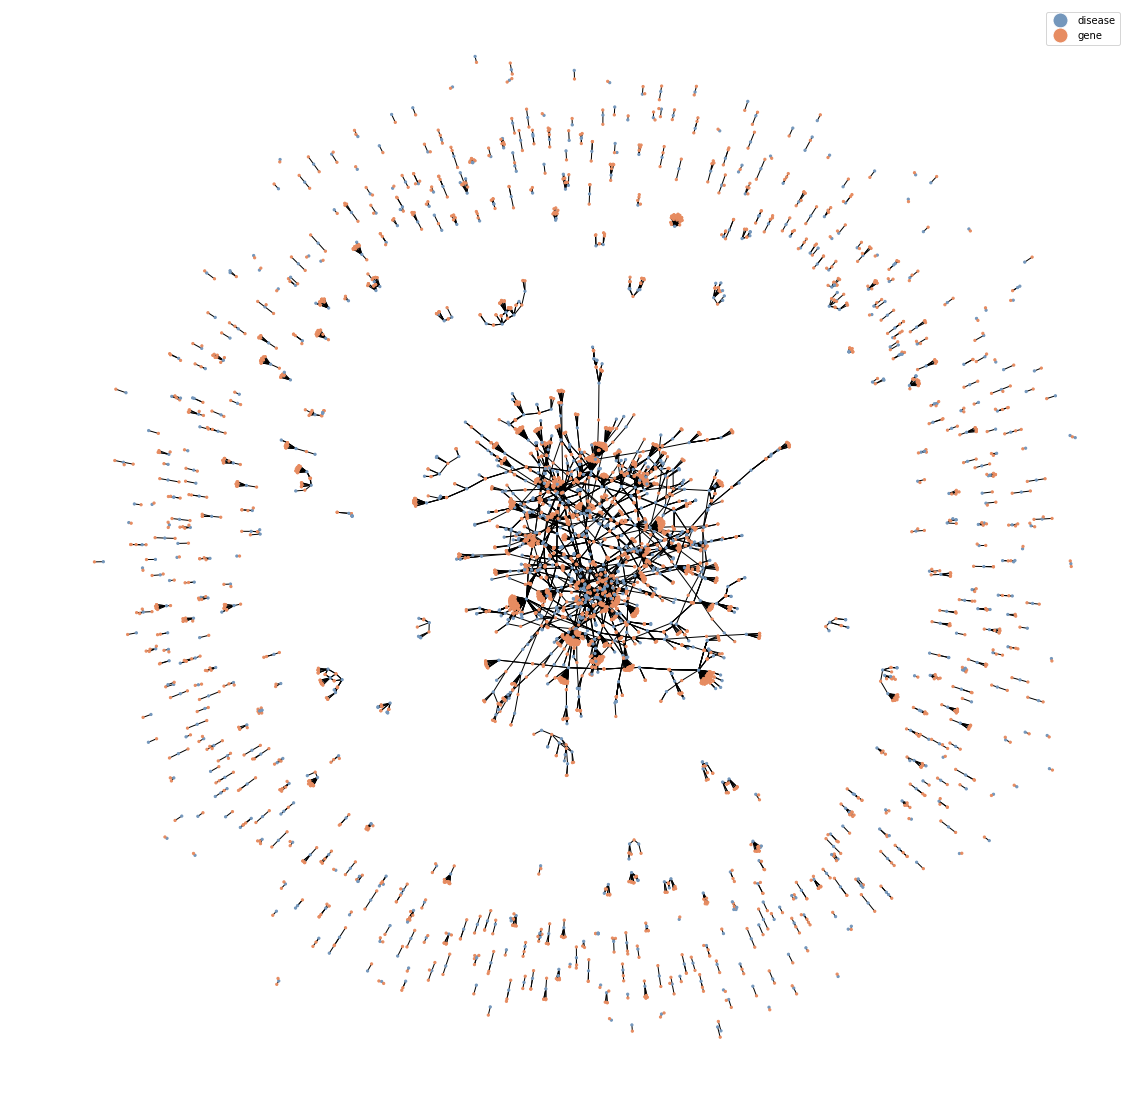

In [8]:
# Initialize figure
plt.figure(figsize=(15,15))
color = {'disease':'#7497bc','gene':'#e78c61'}
nx.draw_spring(G, node_color = [color[G.node[i]["Type"]] for i in G.nodes()], node_size = 5)
legend_elements = [Line2D([0], [0], marker='o', color='w', label=key,
                          markerfacecolor=value, markersize=15) for key, value in color.items()]
plt.legend(handles=legend_elements, loc ="best")
plt.axis('off')
plt.show()

In [10]:
G_gene = seperateType(G,'gene')
G_disease = seperateType(G,'disease')

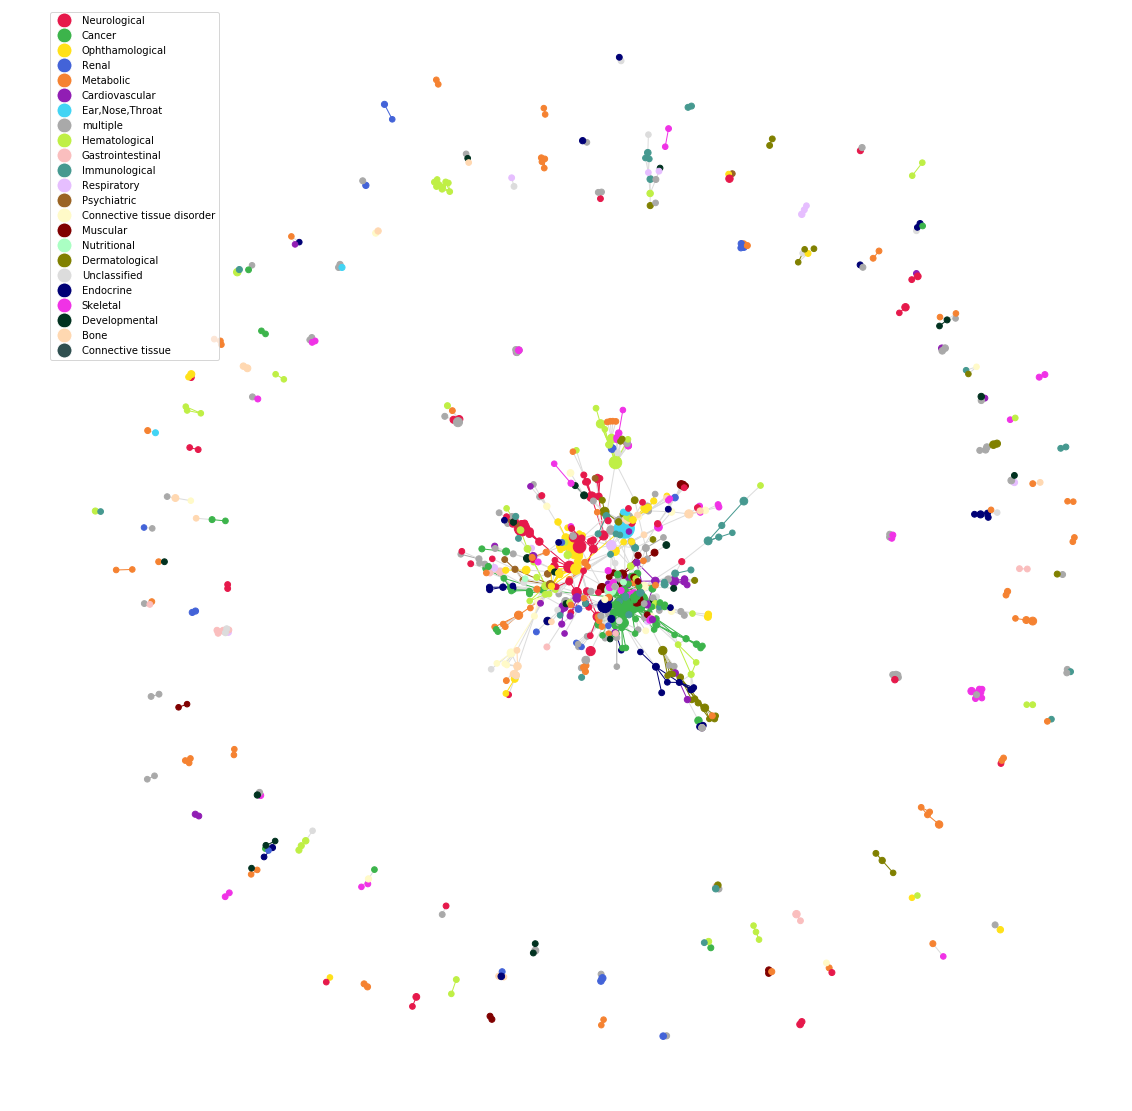

In [11]:
plotGraph(removeSingletons(G_disease), "Class")

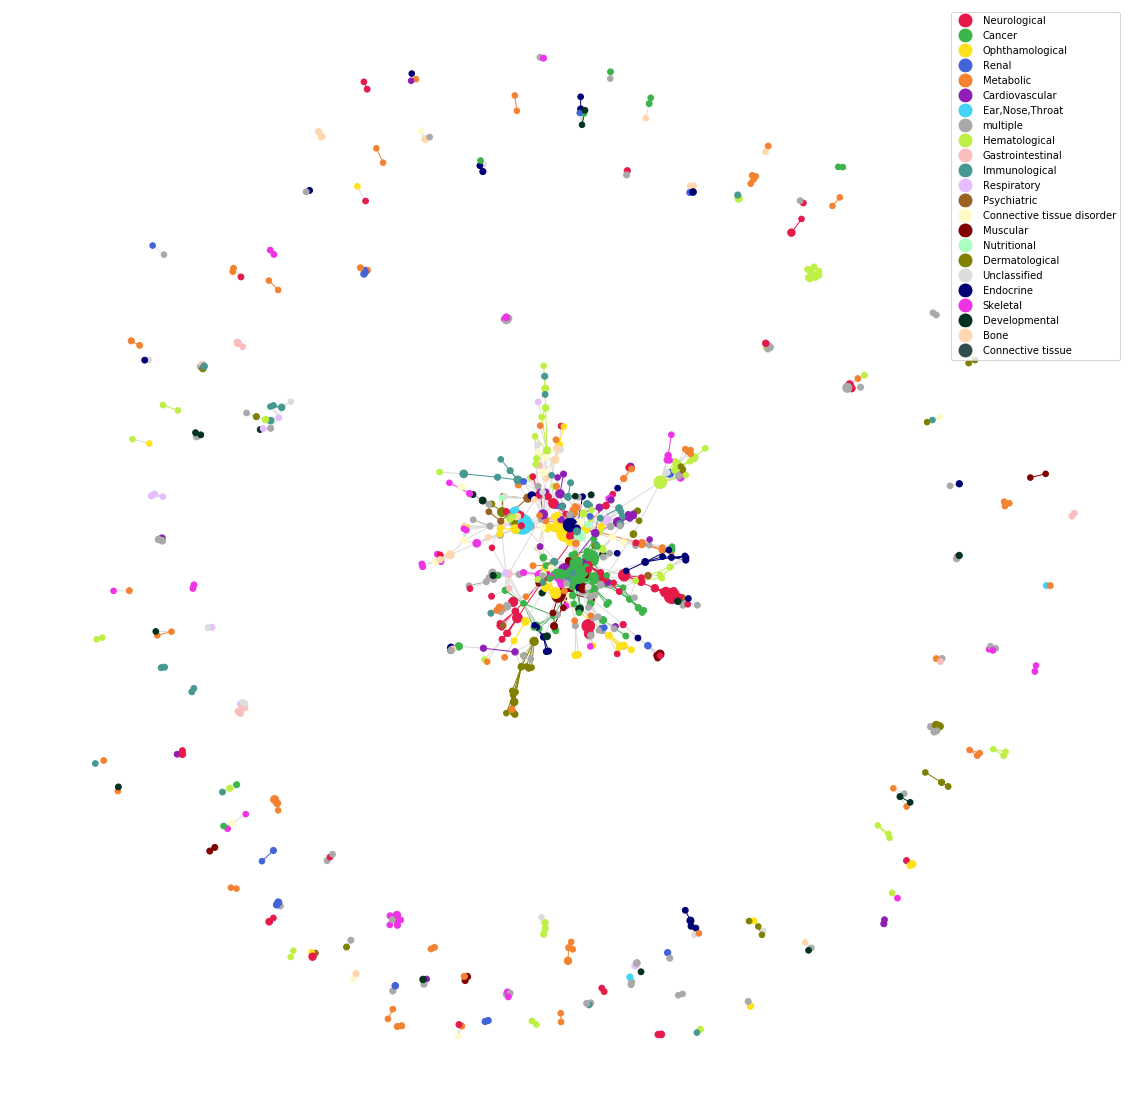

In [12]:
plotGraph(plotGraph(max(nx.connected_component_subgraphs(G_disease), key=len), "Class"), "Class")

Starting at: EYA4


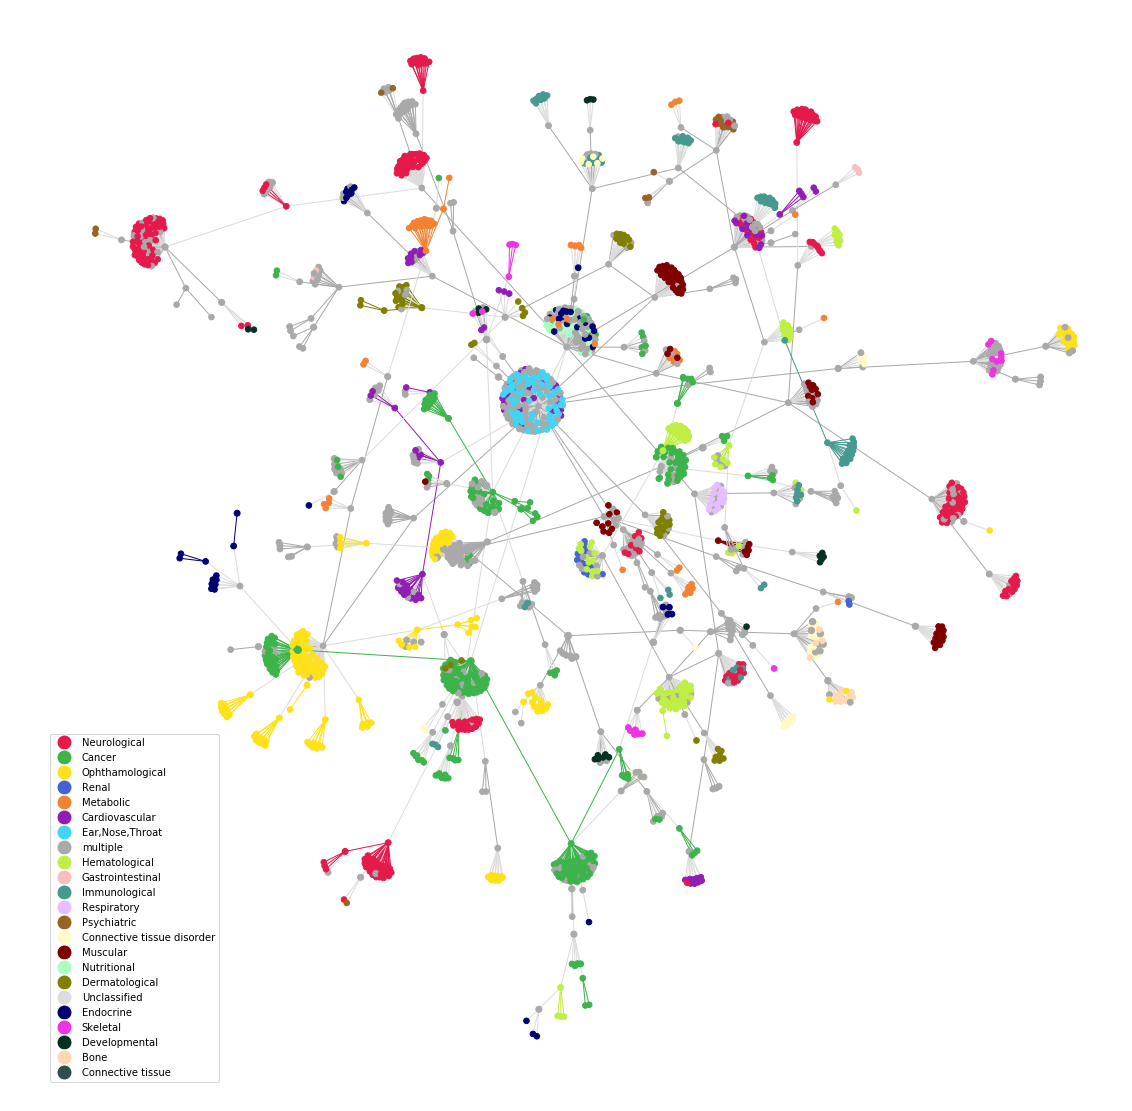

In [13]:
plotGraph(breadthFirstTraversal(G_gene, False), "Class")

In [24]:
# G_gene["NOT"]["PARK4"]["weight"]

1

In [ ]:
singleneighbor(G,i)
secondneighbor(G,i)
weightedfirst(G,i)
function = random(G,i)

prediction(G, MissingNodes, function, alpha):
    function(G,i)